# Классификация возраста, пола и расы по лицу человека

Используйте публичные данные UTKfaces. https://susanqq.github.io/UTKFace/
В работе необходимо использовать данные Aligned&Cropped Faces, где произведены вырезы лиц с исходных изображений.

Изображения хранятся в формате jpg. В имени (почти!!!) каждого иображения имеется информации о человеке

$$[возраст]\_[пол]\_[раса]\_[время].jpg$$

Потребуются первые три параметра из названия каждого файлы.

В текущем файле реализована тренировка сверточной нейронной сети resnet50 для классификации возраста по фотографии. Текущая СНС используется с предобученными весами (transfer learning - перенос обучения) на датасете imagenet. Перенос обучения позволяет использовать веса сети с другого набора данных. Как правило, такой подход позволяет существенно поднять точность предсказания на новом наборе данных.

Задачи:
1. Переписать класс Dataset так, чтобы __getitem__ выдывал классы возраст, пол и раса. Задача регрессии для предсказания возраста является сложно, в этой связи будем решать ее как классификационную. Необходимо закодировать возраст в один из классов [(0, 5), (5, 14), (14, 30), (30, 45), (45, 60), (60, 120)], таким образом __getitem__ будет выдавать номер класса, которому принадлежит человек на фотографии.
Дополнительная задача (по желанию): при классификации ответом является возрастная, а не число. Можно получать возраст в числом выражении если использовать математическое ожидание по ответам нейронной сети. Для этого необходимо умножить ответы в виде Softmax на средние значения возраста в каждой группе и проссумировать все значения. 

2. Переписать класс Net. Добавить Mobilentv2 и Resnet34, так чтобы аргументом net можно было выбрать на основе какого экстрактора признаков построить сеть для классификации. Добавить дополнительные классификаторы для возраста и расы.

3. Обучить сеть. Попробуйте оптимизатор SGD и Adam. Визуализировать результаты на валидационном наборе данных.

Примечание: для тренировки лучше использовать GPU или colab.research.google.com с поддержкой GPU.

In [1]:
import numpy as np
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v2, resnet34, resnet50
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
import torch
from torch.utils.data import Dataset
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Ниже реализован класс Dataset, который имеет три обязательных метода __init__, __len__, __getitem__.

- __init__ происходит инициализация переменных датасета.
- __len__ возращает количество изображений в датасете.
- __getitem__ возвращает изображение в формате PIL и значения классов age, gender, race по индексу.

Размер изображения установить $224 \times 224$. В случае медленного обучения на процессоре параметр можно уменьшить, но потребуется произвести изменения в месте крепления экстрактора признаков и классификатора нейронной сети.

In [2]:
T = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
])

class Dataset_(Dataset):
    'Characterizes a dataset for PyTorch'
    
    def __init__(self, path, subset = 'train', test_part = 0.2, transform = None):
        'Initialization'
        self.path = path
        self.subset = subset
        self.transform = transform
        self.data=torch.Tensor()
        names = [it for it in os.listdir(path) if len(it.split('_')) > 3]
        
        names = [os.path.join(path, it) for it in names]
        np.random.seed(0)
        np.random.shuffle(names)
        if subset == 'train':
            self.ids = names[:int(len(names) * test_part)]
        elif subset == 'valid':
            self.ids = names[int(len(names) * test_part):]

        self.age_list = [(0, 5), (5,14), (14, 30), (30, 45), (45, 60), (60, 120)]
                       
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.ids)

    def __getitem__(self, index):
        'Generates one sample of data'

        ID = self.ids[index]
        
        image = Image.open(ID)

        labels=ID.split('\\')[-1].split('_')

        age = self.mark(int(labels[0]))
        gender = int(labels[1])
        race = int(labels[2])
        
        if self.transform:
            image = self.transform(image)
#             N = transforms.Compose([
#                 transforms.Normalize(self.mean, self.std)
#             ])
#             image=N(image)
        
        return image, age, gender, race
    
    def mark(self, x):
        for i in range(len(self.age_list)):
            if x in range(*self.age_list[i]):
                return i
    
    def compute_mean_and_stf(self):
        for i in tqdm(self.ids):
            image = Image.open(i)
            image = self.transform(image)
            self.data = torch.cat((self.data, image.unsqueeze(0)))
        
        self.mean = np.mean(self.data.numpy(), axis=(0, 2, 3))
        self.std = np.std(self.data.numpy(), axis=(0, 2, 3))

In [3]:
train_data = Dataset_('UTKFace', subset='train', test_part = 0.7, transform = T)
valid_data = Dataset_('UTKFace', subset='valid', test_part = 0.7, transform = T)

In [4]:
# train_data.compute_mean_and_stf()
# valid_data.compute_mean_and_stf()

Ниже представлен пример получения изображения по индексу.

13823 [5, 0, 1]


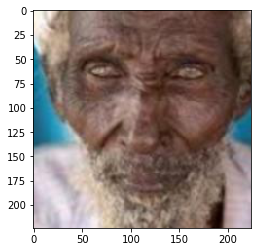

In [62]:
indx=random.randint(0, train_data.__len__())
img, *labels = train_data[indx]
print(indx, labels)
plt.imshow(img.numpy().transpose(1,2,0))

Объекты train_data и valid_data передадим в DataLoader. Объект train_loader и valid_loader будут выдавать пачку изображения с правильными ответами (батчи).

In [6]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=8, 
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_data,
                                          batch_size=8, 
                                          shuffle=False)

[tensor([4, 1, 5, 4, 3, 5, 2, 3]), tensor([0, 0, 1, 0, 1, 1, 1, 0]), tensor([3, 2, 3, 3, 0, 2, 0, 1])]


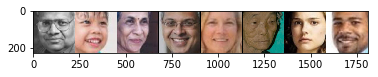

In [7]:
images, *labels = next(iter(train_loader))
plt.imshow(torchvision.utils.make_grid(images).numpy().transpose(1,2,0))
print(labels)

In [8]:
class Net(nn.Module):
    def __init__(self, net='mobilenetv2', pretrained=True):
        super(Net, self).__init__()
        self.net = net
        if self.net == 'mobilenetv2':
            self.model = mobilenet_v2(pretrained=pretrained)
            self.model.age_cls = nn.Linear(model.last_channel, 6)
            self.model.gender_cls = nn.Linear(model.last_channel, 2)
            self.model.race_cls = nn.Linear(model.last_channel, 5)
            
        elif self.net == 'resnet34':
            self.model = resnet34(pretrained=pretrained)
            self.model.age_cls = nn.Linear(self.model.fc.in_features, 6)
            self.model.gender_cls = nn.Linear(self.model.fc.in_features, 2)
            self.model.race_cls = nn.Linear(self.model.fc.in_features, 5)
            
        elif self.net == 'resnet50':
            self.model = resnet50(pretrained=pretrained)
            self.model.age_cls = nn.Linear(self.model.fc.in_features, 6)
            self.model.gender_cls = nn.Linear(self.model.fc.in_features, 2)
            self.model.race_cls = nn.Linear(self.model.fc.in_features, 5)

    def forward(self, x):
        if self.net == 'resnet50':
            x = self.model.conv1(x)
            x = self.model.bn1(x)
            x = self.model.relu(x)
            x = self.model.maxpool(x)
            x = self.model.layer1(x)
            x = self.model.layer2(x)
            x = self.model.layer3(x)
            x = self.model.layer4(x)
            x = self.model.avgpool(x)
            x = x.view(x.size(0), -1)
            age = self.model.age_cls(x)
            gender = self.model.gender_cls(x)
            race = self.model.race_cls(x)
            
        if self.net == 'resnet34':
            x = self.model.conv1(x)
            x = self.model.bn1(x)
            x = self.model.relu(x)
            x = self.model.maxpool(x)
            x = self.model.layer1(x)
            x = self.model.layer2(x)
            x = self.model.layer3(x)
            x = self.model.layer4(x)
            x = self.model.avgpool(x)
            x = x.view(x.size(0), -1)
            age = self.model.age_cls(x)
            gender = self.model.gender_cls(x)
            race = self.model.race_cls(x)
        
        if self.net == 'mobilenetv2':
            x = self.model.forward(x)
            x = x.view(x.size(0), -1)
            gender = self.model.gender_cls(x)
            age = self.model.age_cls(x)
            race = self.model.race_cls(x)
            
        return age, gender, race

In [9]:
# 'resnet50':{'sgd':{},'adam':{}},
results={'resnet34':{'sgd':{},'adam':{}},
         'mobilenetv2':{'sgd':{},'adam':{}}}

In [10]:
for net in results:
    for optmzr in results[net]:

        results[net][optmzr]['loss']=[]
        results[net][optmzr]['val_loss']=[]
        results[net][optmzr]['acc_age']=[]
        results[net][optmzr]['val_acc_age']=[]
        results[net][optmzr]['acc_gender']=[]
        results[net][optmzr]['val_acc_gender']=[]
        results[net][optmzr]['acc_race']=[]
        results[net][optmzr]['val_acc_race']=[]
        
        model = Net(net=net).to(device)

        criterion = nn.CrossEntropyLoss()
        
        optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum = 0.9) if optmzr == 'sgd' else optim.Adam(model.parameters(), lr=1e-3)
        
        print(f'BEGIN {net} {optmzr}')
        
        for epoch in range(1):

            for phase in ['train', 'valid']:

                if phase == 'train':

                    model.train(True)

                    running_loss = 0.0
                    correct = 0
                    total = 0

                    age_correct = 0
                    gender_correct = 0
                    race_correct = 0

                    for i, data in enumerate(train_loader):
                        # get the inputs; data is a list of [inputs, labels]
                        inputs, targets = data[0].to(device), (data[1].to(device), data[2].to(device), data[3].to(device))

                        # zero the parameter gradients
                        optimizer.zero_grad()

                        # forward + backward + optimize
                        out = model(inputs)

                        loss_age = criterion(out[0], targets[0])
                        loss_gender = criterion(out[1], targets[1])
                        loss_race = criterion(out[2], targets[2])

                        loss = loss_age + loss_gender + loss_race

                        loss.backward()
                        optimizer.step()

                        # print statistics
                        running_loss += loss.item()

                        _, age_pred = torch.max(out[0].data, 1)
                        _, gender_pred = torch.max(out[1].data, 1)
                        _, race_pred = torch.max(out[2].data, 1)

                        total += targets[0].size(0)

                        age_correct += (age_pred == targets[0]).sum().item()
                        gender_correct += (gender_pred == targets[1]).sum().item()
                        race_correct += (race_pred == targets[2]).sum().item()

                        del out
                        del inputs
                        
                elif phase == 'valid':

                    model.train(False)

                    validation_loss = 0.
                    v_correct = 0
                    v_total = 0

                    v_age_correct = 0
                    v_gender_correct = 0
                    v_race_correct = 0

                    for j, v_data in enumerate(valid_loader):
                        v_inputs, v_outputs = v_data[0].to(device), (v_data[1].to(device), v_data[2].to(device), v_data[3].to(device))

                        v_out = model(v_inputs)

                        v_loss_age = criterion(v_out[0], v_outputs[0])
                        v_loss_gender = criterion(v_out[1], v_outputs[1])
                        v_loss_race = criterion(v_out[2], v_outputs[2])

                        validation_loss += v_loss_age + v_loss_gender + v_loss_race

                        _, v_age_pred = torch.max(v_out[0].data, 1)
                        _, v_gender_pred = torch.max(v_out[1].data, 1)
                        _, v_race_pred = torch.max(v_out[2].data, 1)

                        v_total += v_outputs[0].size(0)

                        v_age_correct += (v_age_pred == v_outputs[0]).sum().item()
                        v_gender_correct += (v_gender_pred == v_outputs[1]).sum().item()
                        v_race_correct += (v_race_pred == v_outputs[2]).sum().item()

                        del v_out
                        del v_inputs
                        
            print(f"""Epoch {epoch + 1}, 
                        loss: {running_loss / len(train_loader):.3f}, 
                        val_loss: {validation_loss / len(valid_loader):.3f}, 
                        acc_age: {age_correct / total:.3f}, 
                        val_acc_age: {v_age_correct / v_total:.3f}
                        acc_gender: {gender_correct / total:.3f}, 
                        val_acc_gender: {v_gender_correct / v_total:.3f}
                        acc_race: {race_correct / total:.3f}, 
                        val_acc_race: {v_race_correct / v_total:.3f}""" 
                 )
            
            
            results[net][optmzr]['loss'].append(running_loss / len(train_loader))
            results[net][optmzr]['val_loss'].append(validation_loss / len(valid_loader))
            results[net][optmzr]['acc_age'].append(age_correct / total)
            results[net][optmzr]['val_acc_age'].append(v_age_correct / v_total)
            results[net][optmzr]['acc_gender'].append(gender_correct / total)
            results[net][optmzr]['val_acc_gender'].append(v_gender_correct / v_total)
            results[net][optmzr]['acc_race'].append(race_correct / total)
            results[net][optmzr]['val_acc_race'].append(v_race_correct / v_total)

        print(f'END {net} {optmzr}')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\gabma/.cache\torch\checkpoints\resnet34-333f7ec4.pth
100%|█████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:10<00:00, 8.12MB/s]


BEGIN resnet34 sgd


RuntimeError: CUDA out of memory. Tried to allocate 26.00 MiB (GPU 0; 8.00 GiB total capacity; 6.06 GiB already allocated; 11.77 MiB free; 149.87 MiB cached)